In [48]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline

#warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso, ElasticNetCV, ElasticNet, HuberRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

import xgboost as xgb
from sklearn.model_selection import cross_val_score
from xgboost.sklearn import XGBClassifier  
from xgboost.sklearn import XGBRegressor
import scipy.stats as st
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from sklearn.decomposition import PCA


In [33]:
#CARGAMOS LOS DATOS

traindata=pd.read_csv('Dataset_Salesforce_Predictive_Modelling_TRAIN.txt')#reading the data
testdata=pd.read_csv('Dataset_Salesforce_Predictive_Modelling_TEST.txt')
print('Number of rows and columns of the training set: ',traindata.shape)
print('Number of rows and columns of the test set: ',testdata.shape)


/home/fermin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (83) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Number of rows and columns of the training set:  (363834, 89)
Number of rows and columns of the test set:  (156315, 88)


In [34]:
#VARIABLES DE CADA TIPO
list_columns_test=list(testdata.columns.values)
#Ver el nombre de las columnas para saber cuales sumar (buscar la mayor correlación)
list_columns=list(traindata.columns.values)
Names_Imp_cons=list_columns[0:17]
#Importe de consumos habituales del cliente en base a sus operaciones con tarjetas y domiciliaciones más comunes
traindata['Imp_cons_total'] = traindata[Names_Imp_cons].sum(axis=1)
#Importe de los saldos de los distintos productos financieros.
Names_Imp_Sal=list_columns[17:38]
traindata['Imp_sal_total'] = traindata[Names_Imp_Sal].sum(axis=1)
#Tenencia de los distintos productos financieros. Son indices entre 0 y 2 por lo que el sumatorio también valdra
#ya que cuanta más puntuación saque el sumatorio más productos compra
Names_Ind_Prod=list_columns[38:62]
traindata['Ind_prod_total'] = traindata[Names_Ind_Prod].sum(axis=1)
#Número de operaciones a través de los distintos productos financieros.
Names_Num_Oper=list_columns[62:82]
traindata['Num_Oper_total'] = traindata[Names_Num_Oper].sum(axis=1)
#datasetfinal
traindata['Relacion']=((traindata.Imp_sal_total+traindata.Ind_prod_total)*traindata.Num_Oper_total)-traindata.Imp_cons_total
#df = data[['Relacion','Imp_cons_total', 'Imp_sal_total', 'Ind_prod_total','Num_Oper_total','Socio_Demo_01','Socio_Demo_02','Socio_Demo_03','Socio_Demo_04','Socio_Demo_05','Poder_Adquisitivo']].copy()

#hacemos lo mismo con lo de test (la lista que contiene nombres nos sirve la misma)

testdata['Imp_cons_total'] = testdata[Names_Imp_cons].sum(axis=1)
testdata['Imp_sal_total'] = testdata[Names_Imp_Sal].sum(axis=1)
testdata['Ind_prod_total'] = testdata[Names_Ind_Prod].sum(axis=1)
testdata['Num_Oper_total'] = testdata[Names_Num_Oper].sum(axis=1)
testdata['Relacion']=((testdata.Imp_sal_total+testdata.Ind_prod_total)*testdata.Num_Oper_total)-data.Imp_cons_total
traindata.dtypes.value_counts() 

int64      48
float64    44
object      2
dtype: int64

In [35]:
#VARIABLES DE CADA TIPO

numeric_cols=traindata.select_dtypes(include=[np.number]).columns#select only numerical
nominal_cols=traindata.select_dtypes(exclude=[np.number]).columns#select only non numerical
print(numeric_cols.shape[0],'numeric columns: ',numeric_cols)
print(nominal_cols.shape[0],'nominal columns: ',nominal_cols)

92 numeric columns:  Index(['Imp_Cons_01', 'Imp_Cons_02', 'Imp_Cons_03', 'Imp_Cons_04',
       'Imp_Cons_05', 'Imp_Cons_06', 'Imp_Cons_07', 'Imp_Cons_08',
       'Imp_Cons_09', 'Imp_Cons_10', 'Imp_Cons_11', 'Imp_Cons_12',
       'Imp_Cons_13', 'Imp_Cons_14', 'Imp_Cons_15', 'Imp_Cons_16',
       'Imp_Cons_17', 'Imp_Sal_01', 'Imp_Sal_02', 'Imp_Sal_03', 'Imp_Sal_04',
       'Imp_Sal_05', 'Imp_Sal_06', 'Imp_Sal_07', 'Imp_Sal_08', 'Imp_Sal_09',
       'Imp_Sal_10', 'Imp_Sal_11', 'Imp_Sal_12', 'Imp_Sal_13', 'Imp_Sal_14',
       'Imp_Sal_15', 'Imp_Sal_16', 'Imp_Sal_17', 'Imp_Sal_18', 'Imp_Sal_19',
       'Imp_Sal_20', 'Imp_Sal_21', 'Ind_Prod_01', 'Ind_Prod_02', 'Ind_Prod_03',
       'Ind_Prod_04', 'Ind_Prod_05', 'Ind_Prod_06', 'Ind_Prod_07',
       'Ind_Prod_08', 'Ind_Prod_09', 'Ind_Prod_10', 'Ind_Prod_11',
       'Ind_Prod_12', 'Ind_Prod_13', 'Ind_Prod_14', 'Ind_Prod_15',
       'Ind_Prod_16', 'Ind_Prod_17', 'Ind_Prod_18', 'Ind_Prod_19',
       'Ind_Prod_20', 'Ind_Prod_21', 'Ind_Prod_22', 'I

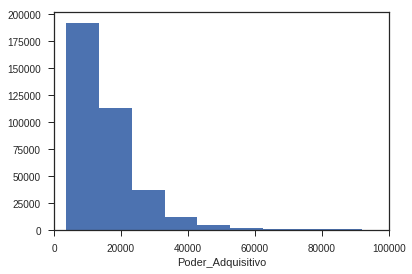

In [58]:
#BARPLOT DEL PODER ADQUISITIVO. 95% DE POBRES CON 5% DE RICOS. ASI DE BIEN VAN LAS COSAS
fig, ax = plt.subplots()
ax.hist(traindata['Poder_Adquisitivo'],100)
ax.set_xlim(0, 100000)
ax.set_xlabel('Poder_Adquisitivo')
plt.show()

In [37]:
description=traindata['Poder_Adquisitivo'].describe()
print(description)
iqr=description['75%']-description['25%']
limits=[description['25%']-1.5*iqr,description['75%']+1.5*iqr]
print('limits (lower,upper)',limits)
#NO HAY NADIE POR DEBAJO DEL LIMITE INFERIOR
print('Valores anomalos',traindata[traindata['Poder_Adquisitivo']>limits[1]].shape[0])
#SON DEMASIADOS. VOY A QUITAR SOLO A LOS MUY RICOS QUE SOLO SON 33 
traindata=traindata[traindata['Poder_Adquisitivo']<=1000000]




count    3.638340e+05
mean     1.642141e+04
std      2.436773e+04
min      3.600960e+03
25%      9.300933e+03
50%      1.292517e+04
75%      1.894854e+04
max      5.040000e+06
Name: Poder_Adquisitivo, dtype: float64
limits (lower,upper) [-5170.4740936249964, 33419.943489375]
Valores anomalos 20840


In [38]:
#EL ID DEL CLIENTE NO NOS SIRVE PARA NADA

#traindata['Poder_Adquisitivo_Ranges']=pd.qcut(traindata['Poder_Adquisitivo'],4,labels=[0,1,2,3])
traindata=traindata.drop('ID_Customer',axis=1) #remove the column from train
test_ids = testdata['ID_Customer'] #save id column from test
testdata=testdata.drop('ID_Customer',axis=1) #remove the column from test
nominal_cols=nominal_cols[nominal_cols!='Id'] #remove the column name from this list as well

#CONCATENAMOS AMBOS CONJUNTOS PARA APLICAR TRANSFORMACIONES
#Sacamos columna para el clasificador


data=pd.concat([traindata,testdata],axis=0,ignore_index=True) #concatenate training and test set for future transformations
print(data['Poder_Adquisitivo'].head())#Don't worry about the SalePrice variable that is not in test. 
print(data['Poder_Adquisitivo'].tail()) #It's filled with NAs

0    19709.915000
1    37497.492167
2     4802.970000
3     8295.770000
4    24149.321667
Name: Poder_Adquisitivo, dtype: float64
520111   NaN
520112   NaN
520113   NaN
520114   NaN
520115   NaN
Name: Poder_Adquisitivo, dtype: float64


In [39]:
#VALORES NUMERICOS FALTANTES

missing_values=data.isnull().sum() #obtain the number of missing values by column
numeric_missing=missing_values[numeric_cols] #separate the numeric variables
numeric_missing['Poder_Adquisitivo']=0 #We don't want to detect SalePrice's NAs because they are not real, they just belong to test set
numeric_missing[numeric_missing>0]

#NO FALTAN VALORES NUMERICOS

Series([], dtype: int64)

In [40]:
#VALORES NOMINALES FALTANTES

nominal_missing=missing_values[nominal_cols] 
nominal_missing=nominal_missing[nominal_missing>0]
nominal_missing_df= pd.DataFrame()
nominal_missing_df[['absolute','relative']]= pd.concat([nominal_missing,nominal_missing/data.shape[0]],axis=1)
nominal_missing_df

#HABRA QUE ESTUDIAR BIEN LA COLUMNA Socio_Demo_01, DE MOMENTO ME LA CARGO PARA QUE ESTO FUNCIONE

data=data.drop(['Socio_Demo_01'],axis=1) #remove columns
nominal_cols=nominal_cols[nominal_cols!='Socio_Demo_01']



In [41]:
stdSc = StandardScaler()

numeric_cols=numeric_cols[numeric_cols!='Poder_Adquisitivo'] #We don't want to scale SalePrice

data.loc[:, numeric_cols] = stdSc.fit_transform(data.loc[:, numeric_cols])

In [42]:
#SEPARAMOS DE NUEVO LOS CONJUNTOS

traindata=data.iloc[:traindata.shape[0],:] 
testdata=data.iloc[traindata.shape[0]:,:]
testdata=testdata.drop('Poder_Adquisitivo',axis=1) #We drop the unknown variable in the test. It was just filled with NAs

X_traindata=traindata.drop('Poder_Adquisitivo',axis=1)
y_traindata=traindata['Poder_Adquisitivo']


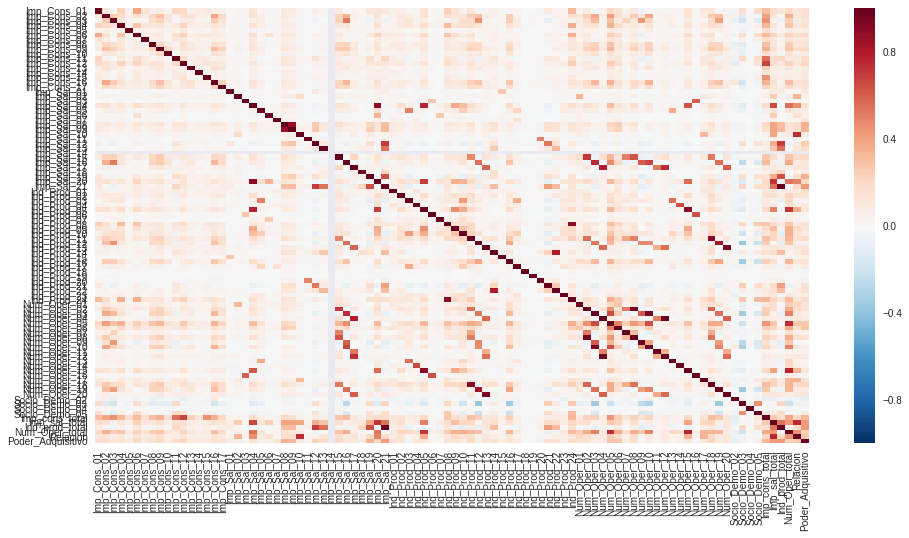

In [24]:
numeric_cols=np.hstack([numeric_cols,'Poder_Adquisitivo'])

#MATRIZ DE CORRELACIONES CON TODAS LAS VARIABLES
correlation=traindata[numeric_cols].corr() #obtain the correlation matrix
sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(correlation,ax=ax)
plt.show() #draw the correlation matrix

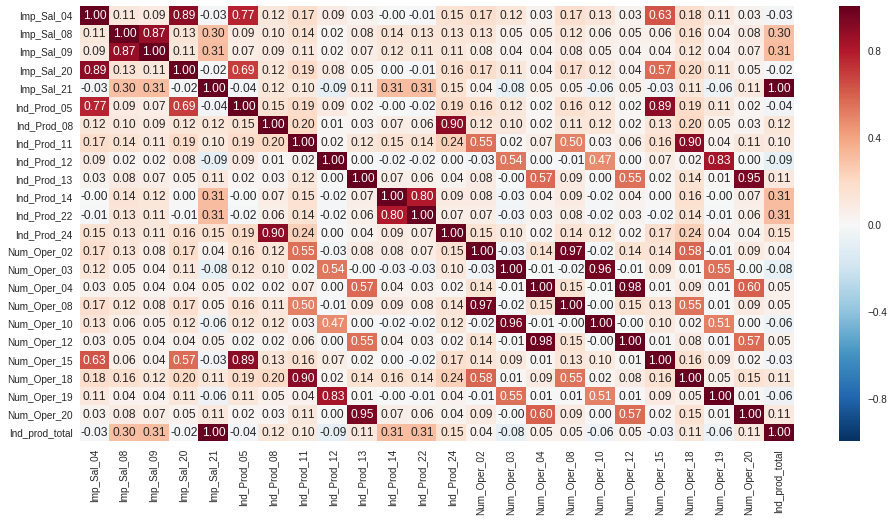

In [25]:
#ESTO ES PARA ENCONTRAR VARIABLES REPETIDAS, LAS QUE TIENEN UNA FUERTE CORRELACION ENTRE ELLAS
#MOSTRAMOS SOLO LAS VARIABLES QUE TIENEN UNA FUERTE CORRELACION CON ALGUNA OTRA
aux=(abs(correlation)-np.identity(correlation.shape[0])).max() #maximum correlation of each variable
selected_feats=aux[aux>0.8].index#take only variables whose maximum correlation is strong.
sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(correlation.loc[selected_feats,selected_feats], annot=True,fmt='.2f',ax=ax)
plt.show()

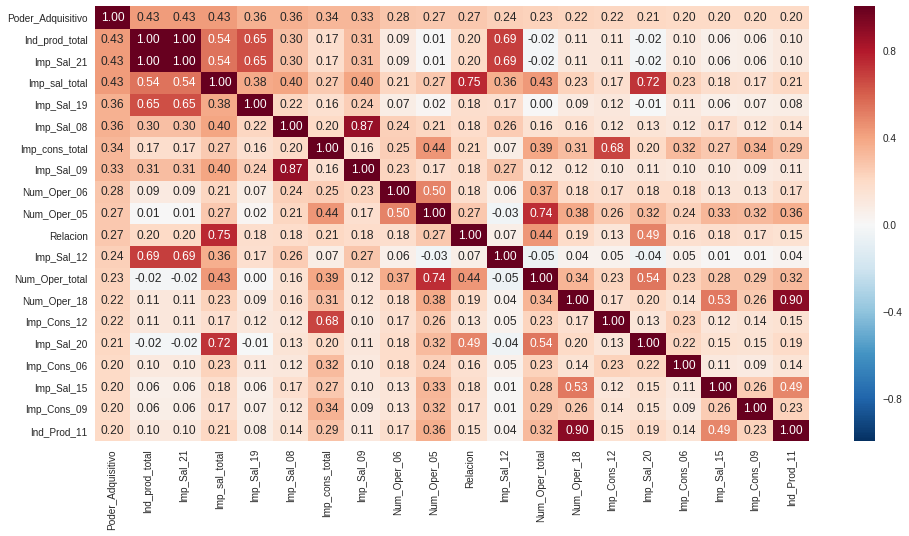

In [26]:
#VAMOS A MOSTRAR LAS SOLO 20 MEJORES VARIABLES
aux=abs(correlation['Poder_Adquisitivo']).sort_values(ascending=False) #sort variables by their correlation with SalePrice
selected_feats=aux[0:20].index
sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(correlation.loc[selected_feats,selected_feats], annot=True,fmt='.2f',ax=ax)
plt.show()

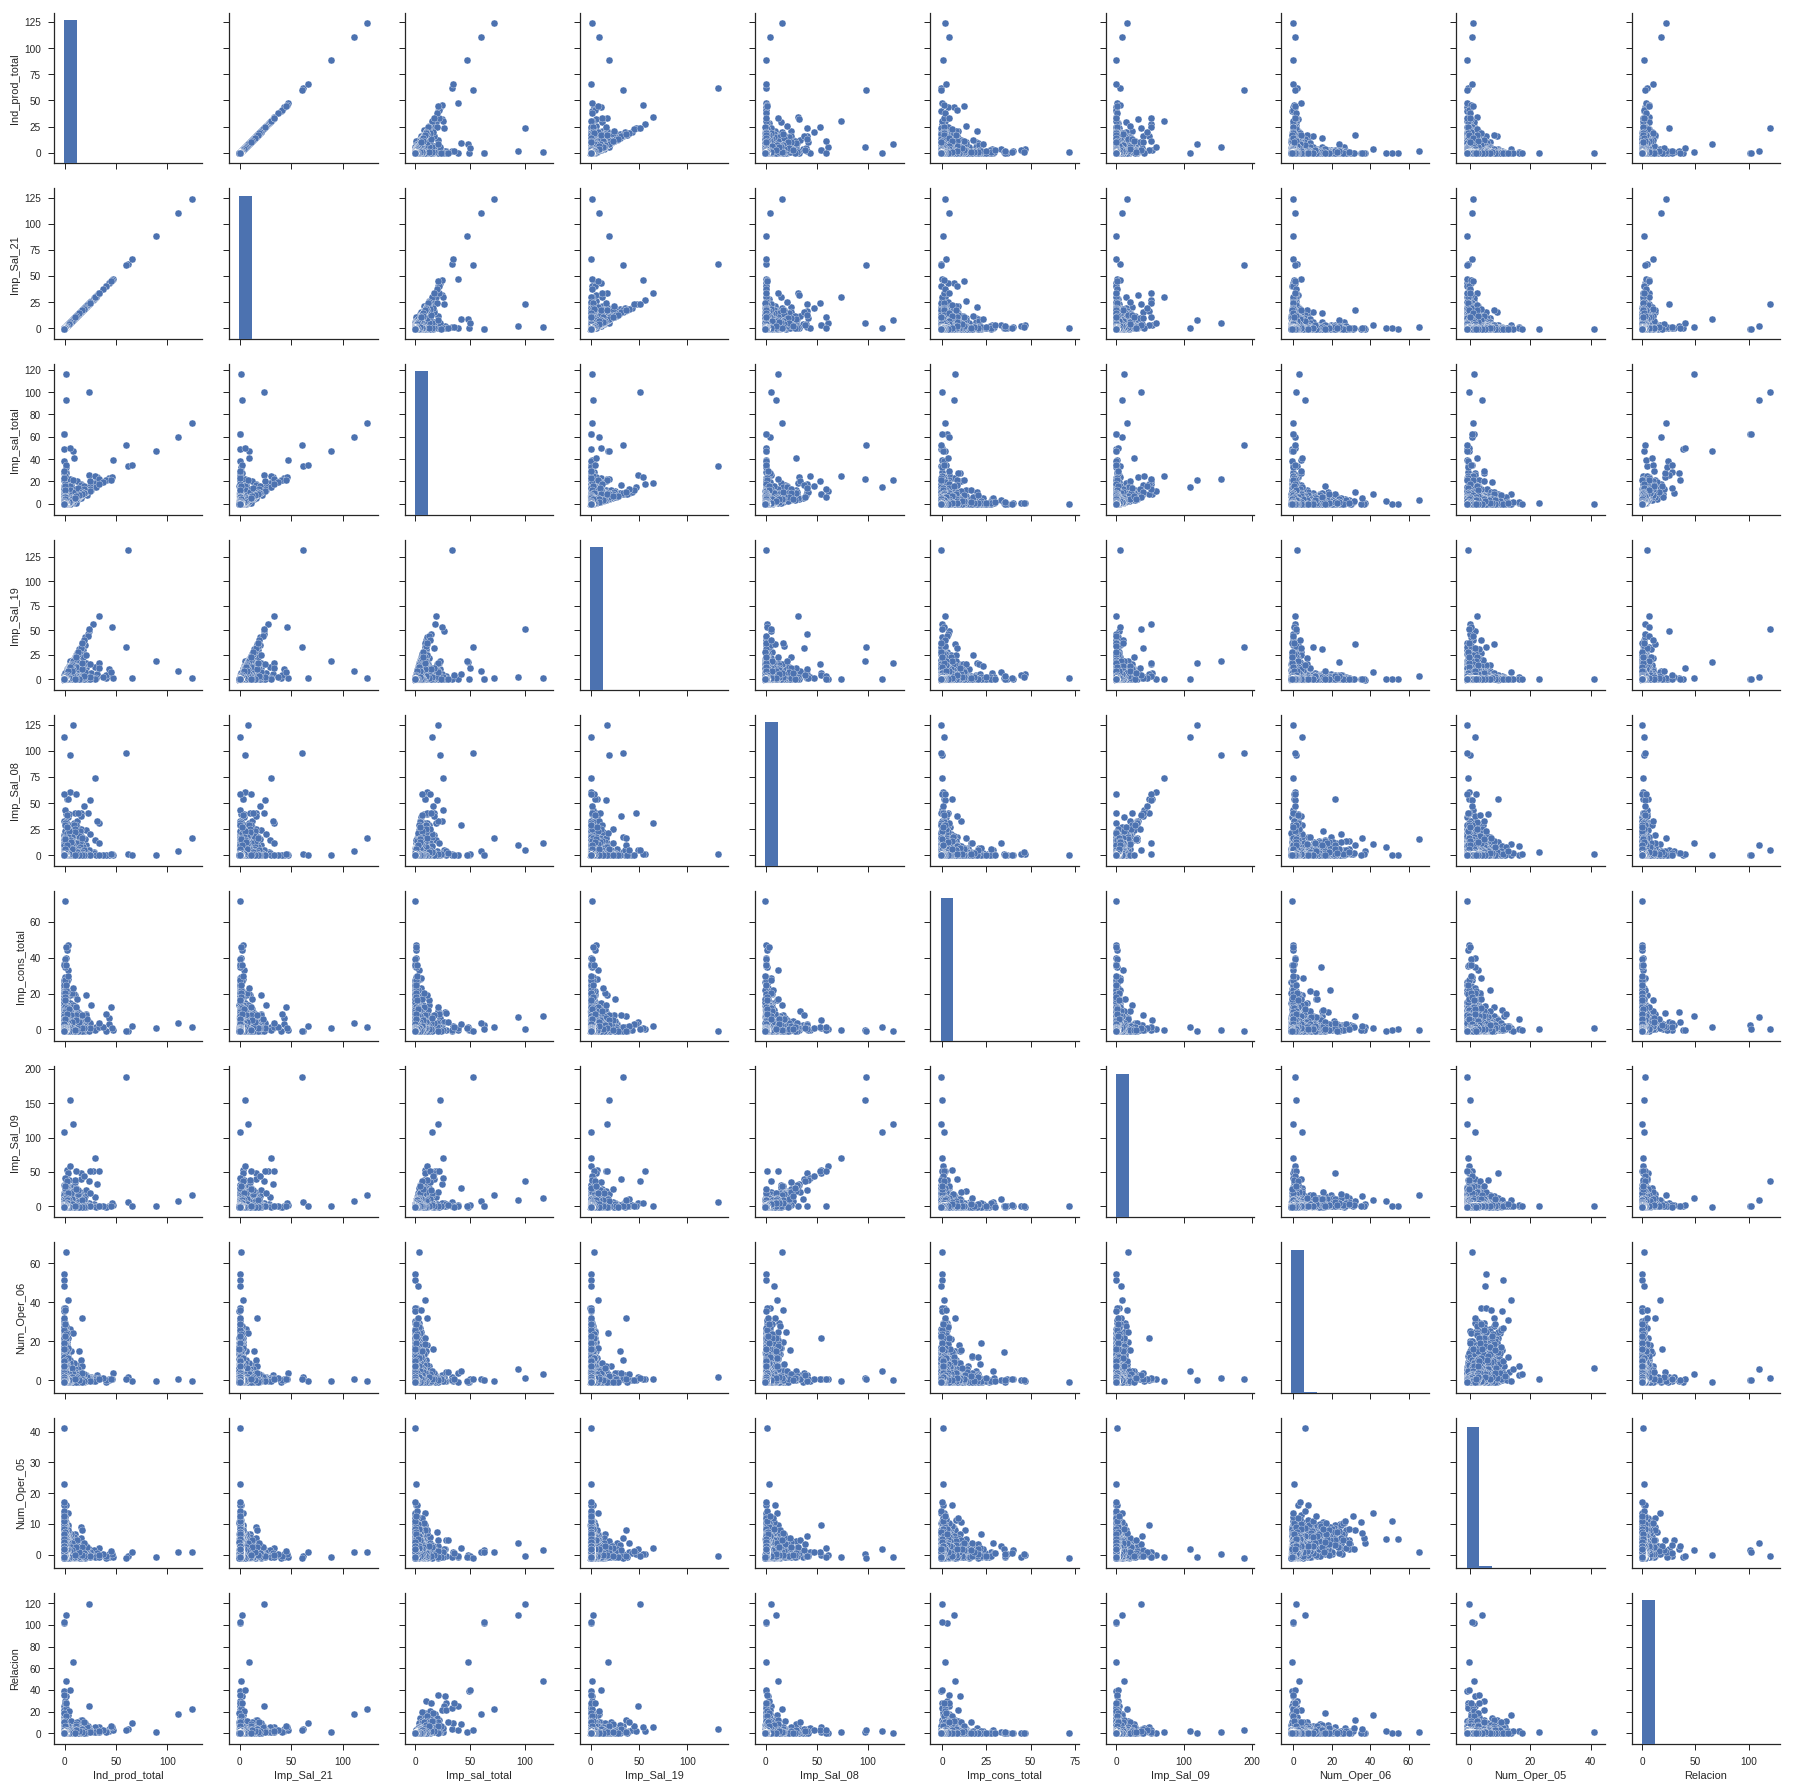

In [27]:
#MOSTRAR SCATTER MATRIX DE LAS 10 MEJORES VARIABLES SIN CONTAR LA OBJETIVO
selected_feats=aux[1:11].index
sns.set(style="ticks")
sns.pairplot(traindata[selected_feats])
plt.show()

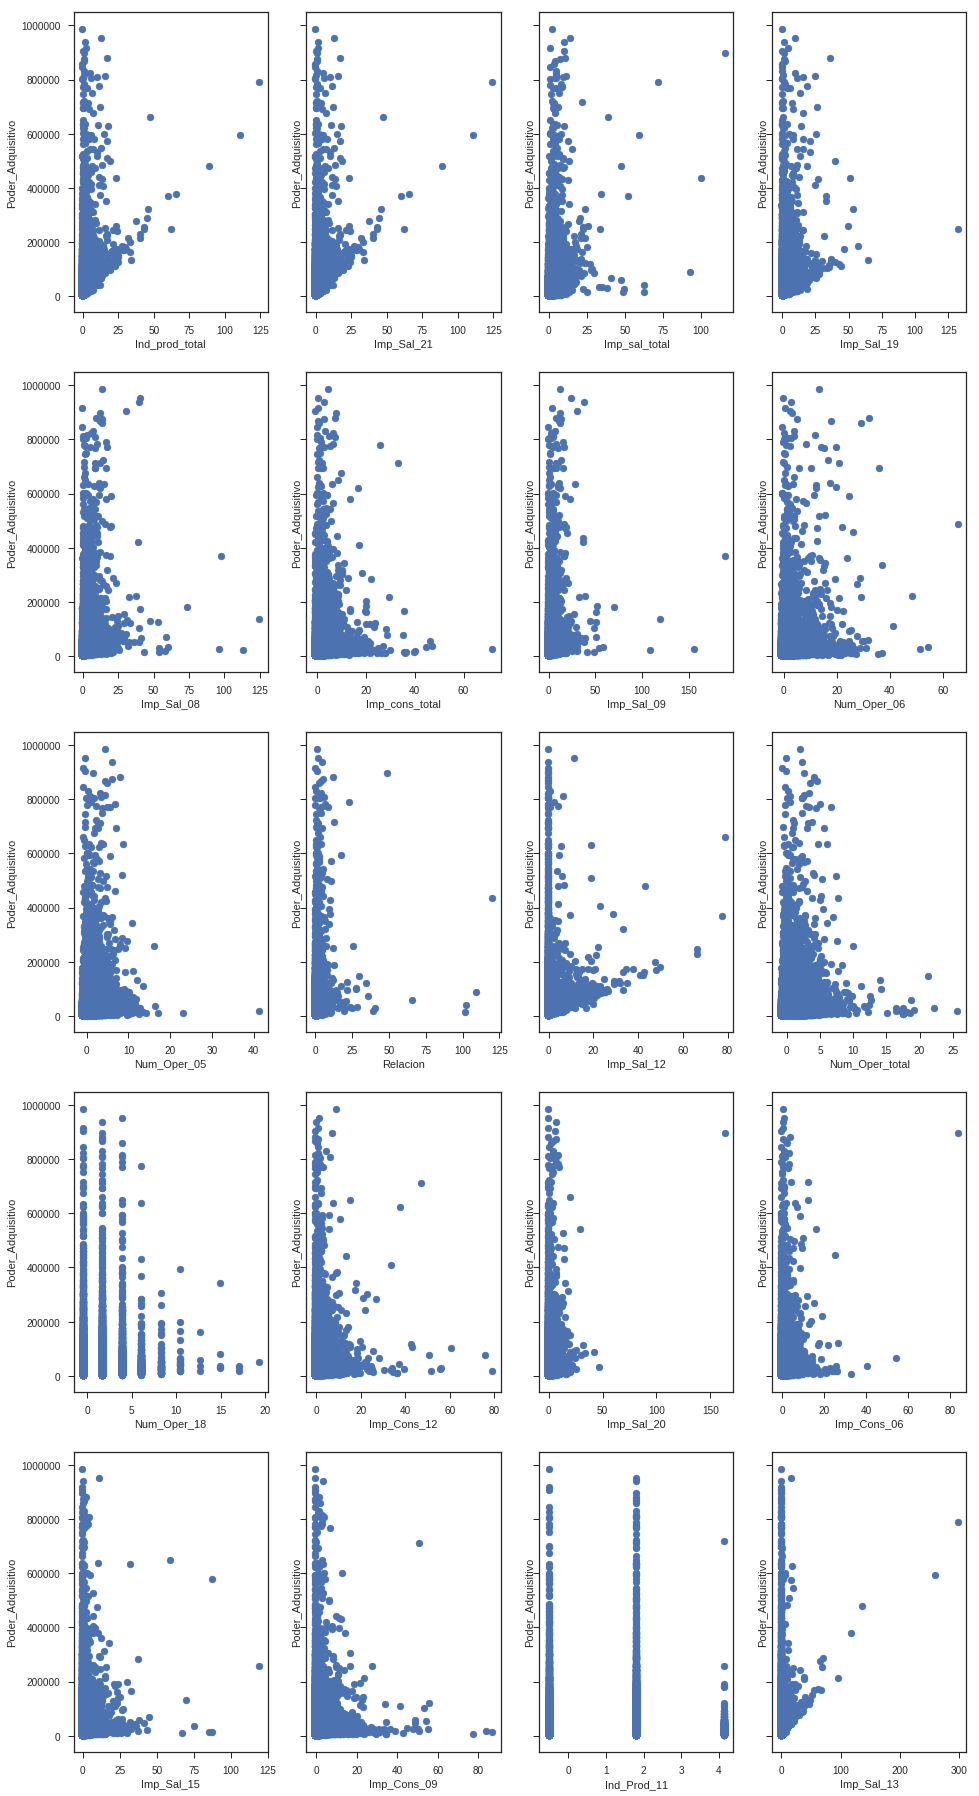

In [28]:
#SCATTERS DE LAS VARIABLES MAS IMPORTANTES CON LA OBJETIVO

selected_feats=aux[1:21].index

fig, axes = plt.subplots(nrows=5,ncols=4,figsize=(16,32),sharey=True)
axes=axes.flatten()
for i in range(len(axes)):
    axes[i].scatter(traindata[selected_feats[i]],traindata['Poder_Adquisitivo'])
    axes[i].set_xlabel(selected_feats[i])
    axes[i].set_ylabel('Poder_Adquisitivo')
plt.show()

In [59]:
#ESTA FUNCIÓN CALCULA EL ERROR ABSOLUTO MEDIO CON CROSS VALIDATION
def rmse_cv(model,X, y):
    return -cross_val_score(model, X, y, scoring = scorer, cv = 10,n_jobs=-1)
#mean_absolute_error
scorer = make_scorer(mean_absolute_error, greater_is_better = False)



In [60]:
#xgboost params (2 regresor)
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

xgbreg = XGBRegressor(nthreads=-1)  
gs = RandomizedSearchCV(xgbreg, params, n_jobs=-1)  
gs.fit(X_traindata, y_traindata)
mae2=rmse_cv(gs.best_estimator_,X_traindata, y_traindata).mean()
mae2


KeyboardInterrupt: 

In [45]:
'''
gbm = lgb.LGBMRegressor(objective='regression',
                        num_leaves=31,
                        learning_rate=1,
                        n_estimators=2)
gbm.fit(X_traindata, y_traindata)


# other scikit-learn modules
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40,80,160,320,1024]
}

gbm = GridSearchCV(estimator, param_grid, n_jobs=-1)

gbm.fit(X_traindata, y_traindata)

print('Best parameters found by grid search are:', gbm.best_params_)

'''
mae2

NameError: name 'mae2' is not defined

In [62]:
#model_lgb = lgb.LGBMRegressor()


mae2


5175.5608316592716

In [54]:
principalDf = pd.DataFrame(data = X_trainPCA)

ValueError: DataFrame constructor not properly called!

In [ ]:
'''
gbm2 = lgb.LGBMRegressor(objective='regression',
                        num_leaves=31,
                        learning_rate=1,
                        n_estimators=1024)

gbm.fit(X_traindata, y_traindata)

mae3=rmse_cv(gbm2,X_traindata, y_traindata).mean()
mae3
'''

UnboundLocalError: local variable 'arrays' referenced before assignment